# RandomForestClassifier

Este modelo se trata de un ensamble de muchos árboles de decisión, con el fin de reducir la varianza del modelo resultante. Como ya entrenamos un árbol de decisión simple, podemos usar los hiperparámetros conseguidos en dicho modelo como estimador base para el random forest.

In [11]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from joblib import dump, load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Métricas y scorings

In [2]:
SCORINGS = ["f1", "roc_auc", "accuracy", "recall", "precision"]
METRIC = "roc_auc"

def tabla(grid, params):
    tabla = pd.DataFrame(grid.cv_results_)
    tabla.sort_values("rank_test_" + METRIC, inplace = True)
    tabla.reset_index(inplace = True)
    cols = ["param_rf__" + x for x in params] + ["mean_test_" + x for x in SCORINGS]
    return tabla[cols]

## Preprocessing

In [4]:
initialize_dataset()
df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory=False, index_col = "id")

common(df_features, df_target, fecha_to_int=False)

viento_trigonometrico(df_features)
df_features = dia_a_mes(df_features)
# Dropeamos la feature de barrio porque vimos que en los arboles de decision
# no fue una feature util
df_features.drop(columns="barrio", inplace=True)

## Grid search de hiperparámetros

In [5]:
parameters = {
    "rf__n_estimators": np.arange(10,500,50),
}

pipe = Pipeline([
    ("imp", SimpleImputer()),
    ("rf", RandomForestClassifier(criterion="entropy", max_depth=10, min_samples_split=575, random_state=0))
])

grid = GridSearchCV(pipe, param_grid=parameters,
                                       cv = 5,
                                       scoring = SCORINGS,
                                       refit=METRIC,
                                       n_jobs = -1)

grid.fit(df_features, df_target.values.ravel())
grid.best_score_

0.8693378779169398

In [6]:
tabla(grid, ["n_estimators"]).head(10)

,param_rf__n_estimators,mean_test_f1,mean_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision
0,360,0.547601,0.869338,0.843636,0.422705,0.777377
1,460,0.548166,0.869225,0.843733,0.423403,0.777301
2,410,0.546868,0.869166,0.843382,0.422137,0.776323
3,310,0.548494,0.869131,0.843558,0.424450,0.775121
4,160,0.548688,0.869070,0.843352,0.425323,0.772943
5,210,0.547847,0.868995,0.843528,0.423403,0.775981
6,110,0.546620,0.868994,0.843274,0.422006,0.775749
7,260,0.547227,0.868980,0.843479,0.422486,0.776586
8,60,0.546659,0.868731,0.843411,0.421700,0.776957
9,10,0.546884,0.865070,0.842014,0.425934,0.764267


Los modelos resultaron ser un poco mejores que al utilizar un único árbol (~87% vs ~85.6% en AUC ROC). Es interesante notar que los modelos con pocos estimadores también dieron buenos resultados. Sin embargo, no es un hiperparámetro que suela generar overfit, por lo que podemos decir que el mejor modelo resultante de este entrenamiento es el primero

In [7]:
dump(grid.best_estimator_, 'RandomForestClassifier/preprocessing1.joblib')

['RandomForestClassifier/preprocessing1.joblib']

### Matriz de confusión

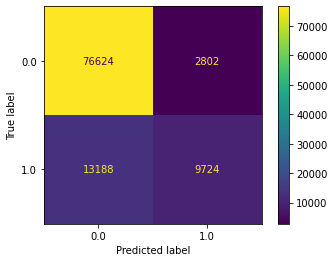

In [13]:
ConfusionMatrixDisplay.from_predictions(df_target.values.ravel(), cross_val_predict(grid.best_estimator_, df_features, df_target.values.ravel()))

Tal y como vimos con los árboles de decisión, hay una gran cantidad de falsos negativos. Podemos intentar mejorar esto balanceando los pesos de las clases

## Balanceo de pesos

In [15]:
parameters = {
    "rf__n_estimators": np.arange(100,500,100),
}

pipe = Pipeline([
    ("imp", SimpleImputer()),
    ("rf", RandomForestClassifier(criterion="entropy", max_depth=10, min_samples_split=575, class_weight="balanced", random_state=0))
])

grid = GridSearchCV(pipe, param_grid=parameters,
                                       cv = 5,
                                       scoring = SCORINGS,
                                       refit=METRIC,
                                       n_jobs = -1)

grid.fit(df_features, df_target.values.ravel())
grid.best_score_

0.870050737367594

In [16]:
tabla(grid, ["n_estimators"])

,param_rf__n_estimators,mean_test_f1,mean_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision
0,300,0.622370,0.870051,0.789042,0.776405,0.519348
1,400,0.622323,0.870016,0.788798,0.777147,0.518950
2,200,0.621659,0.869931,0.788260,0.776929,0.518126
3,100,0.621311,0.869674,0.788290,0.775663,0.518215


Los resultados fueron prácticamente iguales, por lo que no parece ser un parámetro relevante, tal y como ocurrió con los árboles de decisión.

### Importancia de las features

In [20]:
pd.DataFrame(zip(df_features.columns, grid.best_estimator_[1].feature_importances_), columns=["feature", "importancia"])\
.set_index("feature")\
.sort_values(by="importancia", ascending=False)\
.head(10)

,importancia
feature,
humedad_tarde,0.322118
mm_lluvia_dia,0.124898
horas_de_sol,0.105567
nubosidad_tarde,0.077518
presion_atmosferica_tarde,0.060258
rafaga_viento_max_velocidad,0.058960
humedad_temprano,0.058042
presion_atmosferica_temprano,0.054022
nubosidad_temprano,0.032712


In [22]:
pd.DataFrame(zip(df_features.columns, grid.best_estimator_[1].feature_importances_), columns=["feature", "importancia"])\
.set_index("feature")\
.sort_values(by="importancia", ascending=False)\
.tail(10)

,importancia
feature,
sin_viento_temprano,0.009959
temperatura_temprano,0.009231
velocidad_viento_tarde,0.005205
mm_evaporados_agua,0.004582
sin_rafaga_viento_max_direccion,0.003963
cos_rafaga_viento_max_direccion,0.003736
velocidad_viento_temprano,0.003167
cos_viento_tarde,0.003142
mes,0.002315


A diferencia de los árboles de decisión, en el random forest las importancias de las features se encuentran distribuidas de una forma más equitativa. Esto es porque cada árbol recibe un subset de features que puede utilizar para las predicciones, por lo que no siempre podrá utilizar los mejores predictores del dataset

In [23]:
dump(grid.best_estimator_, 'RandomForestClassifier/balanced.joblib')

['RandomForestClassifier/balanced.joblib']